In [443]:
import warnings
warnings.filterwarnings("ignore")

In [444]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.stats import mode, pearsonr

In [445]:
np.random.seed(13)

## Pre-Processing Data

"This dataset contains credit card transactions made by European cardholders in the year 2023. It comprises over 550,000 records, and the data has been anonymized to protect the cardholders' identities. The primary objective of this dataset is to facilitate the development of fraud detection algorithms and models to identify potentially fraudulent transactions." 

Source: https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023?resource=download

In [446]:

DATA_DF = pd.read_csv('data/creditcard_2023.csv')

print(DATA_DF.columns)
for col in DATA_DF.columns:
    DATA_DF[col] = pd.to_numeric(DATA_DF[col], errors='ignore')

DATA_DF['Class'] = DATA_DF['Class'].astype('category')


Index(['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')



#### Features
id: Unique identifier for each transaction

V1-V28: Anonymized features representing various transaction attributes (e.g., time, location, etc.)

Amount: The transaction amount

Class: Binary label indicating whether the transaction is fraudulent (1) or not (0)

## Question 1
Display the statistical values for each of the attributes, along with visualizations (e.g., histogram) of the distributions for each attribute. Are there any attributes that might require special treatment? If so, what special treatment might they require? 

In [447]:
DATA_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   id      568630 non-null  int64   
 1   V1      568630 non-null  float64 
 2   V2      568630 non-null  float64 
 3   V3      568630 non-null  float64 
 4   V4      568630 non-null  float64 
 5   V5      568630 non-null  float64 
 6   V6      568630 non-null  float64 
 7   V7      568630 non-null  float64 
 8   V8      568630 non-null  float64 
 9   V9      568630 non-null  float64 
 10  V10     568630 non-null  float64 
 11  V11     568630 non-null  float64 
 12  V12     568630 non-null  float64 
 13  V13     568630 non-null  float64 
 14  V14     568630 non-null  float64 
 15  V15     568630 non-null  float64 
 16  V16     568630 non-null  float64 
 17  V17     568630 non-null  float64 
 18  V18     568630 non-null  float64 
 19  V19     568630 non-null  float64 
 20  V20     568630 non-null  f

Take a random sample of 5000 rows to improve compute times

In [448]:
DATA_DF = DATA_DF.sample(n=5000, random_state=42).drop(columns=['id'])
DATA_DF['Class'].value_counts()

Class
0    2515
1    2485
Name: count, dtype: int64

### Statistical Values

Basic Statistical Values

In [449]:
DATA_DF.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.013514,-0.014273,0.001791,-0.000965,0.002450,-0.001288,0.001584,-0.001291,0.000804,-0.004252,...,-0.008074,-0.013858,0.023265,0.016828,0.002726,-0.001195,0.009892,-0.009123,-0.019257,12064.556622
std,0.994552,0.935929,0.989419,0.998819,0.934012,0.976597,0.950599,0.926536,0.974956,0.960948,...,0.919095,0.944612,0.957266,0.878355,1.005066,0.971992,0.988606,0.976009,1.021196,6931.191554
min,-2.633037,-6.524711,-2.514274,-3.469685,-3.293834,-3.907917,-4.282783,-6.401165,-3.748689,-3.154772,...,-11.471414,-11.797024,-6.450353,-12.405493,-4.051283,-5.755634,-3.540501,-4.947034,-20.993100,54.910000
25%,-0.569496,-0.500251,-0.633671,-0.650786,-0.279385,-0.435528,-0.280940,-0.189653,-0.561239,-0.582095,...,-0.341943,-0.165958,-0.472360,-0.230524,-0.668020,-0.551848,-0.623710,-0.304435,-0.226726,6041.415000
50%,-0.086256,-0.147009,0.002463,-0.079016,0.085600,0.063272,0.231362,-0.112700,0.106674,0.279780,...,-0.117591,-0.039406,-0.011325,-0.056235,0.024723,-0.000457,-0.003994,-0.173571,-0.015641,12124.225000
75%,0.849520,0.329037,0.627774,0.690907,0.444253,0.484901,0.521322,0.043562,0.574060,0.589887,...,0.235355,0.139231,0.474929,0.164194,0.714839,0.546240,0.692693,0.328298,0.386932,18180.317500
max,2.127090,4.310753,4.197537,2.358688,7.200170,6.853794,19.857485,5.934532,6.687294,9.103646,...,9.048605,8.087080,9.763528,8.099317,8.262604,3.896368,4.449529,7.903031,12.400147,24036.260000


Check Null and Missing Values

In [450]:
DATA_DF.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Plotting Histograms

In [451]:
COLORMAP = plt.cm.plasma
SNS_COLORMAP = sns.color_palette("plasma", n_colors=len(DATA_DF.columns))

Selecting the top 10 features with the highest absolute correlation statistic to our target value, these features were pulled from Question 2 Pearson Correlation Coefficient. This is done to simplify the amount of visualizaions of the histograms and scatter plots

In [452]:
TOP_15_FEATURES = ['V14', 'V12', 'V4', 'V11', 'V3', 'V10', 'V9', 'V16', 'V1', 'V2', 'V7', 'V17', 'V6', 'V18', 'V5']

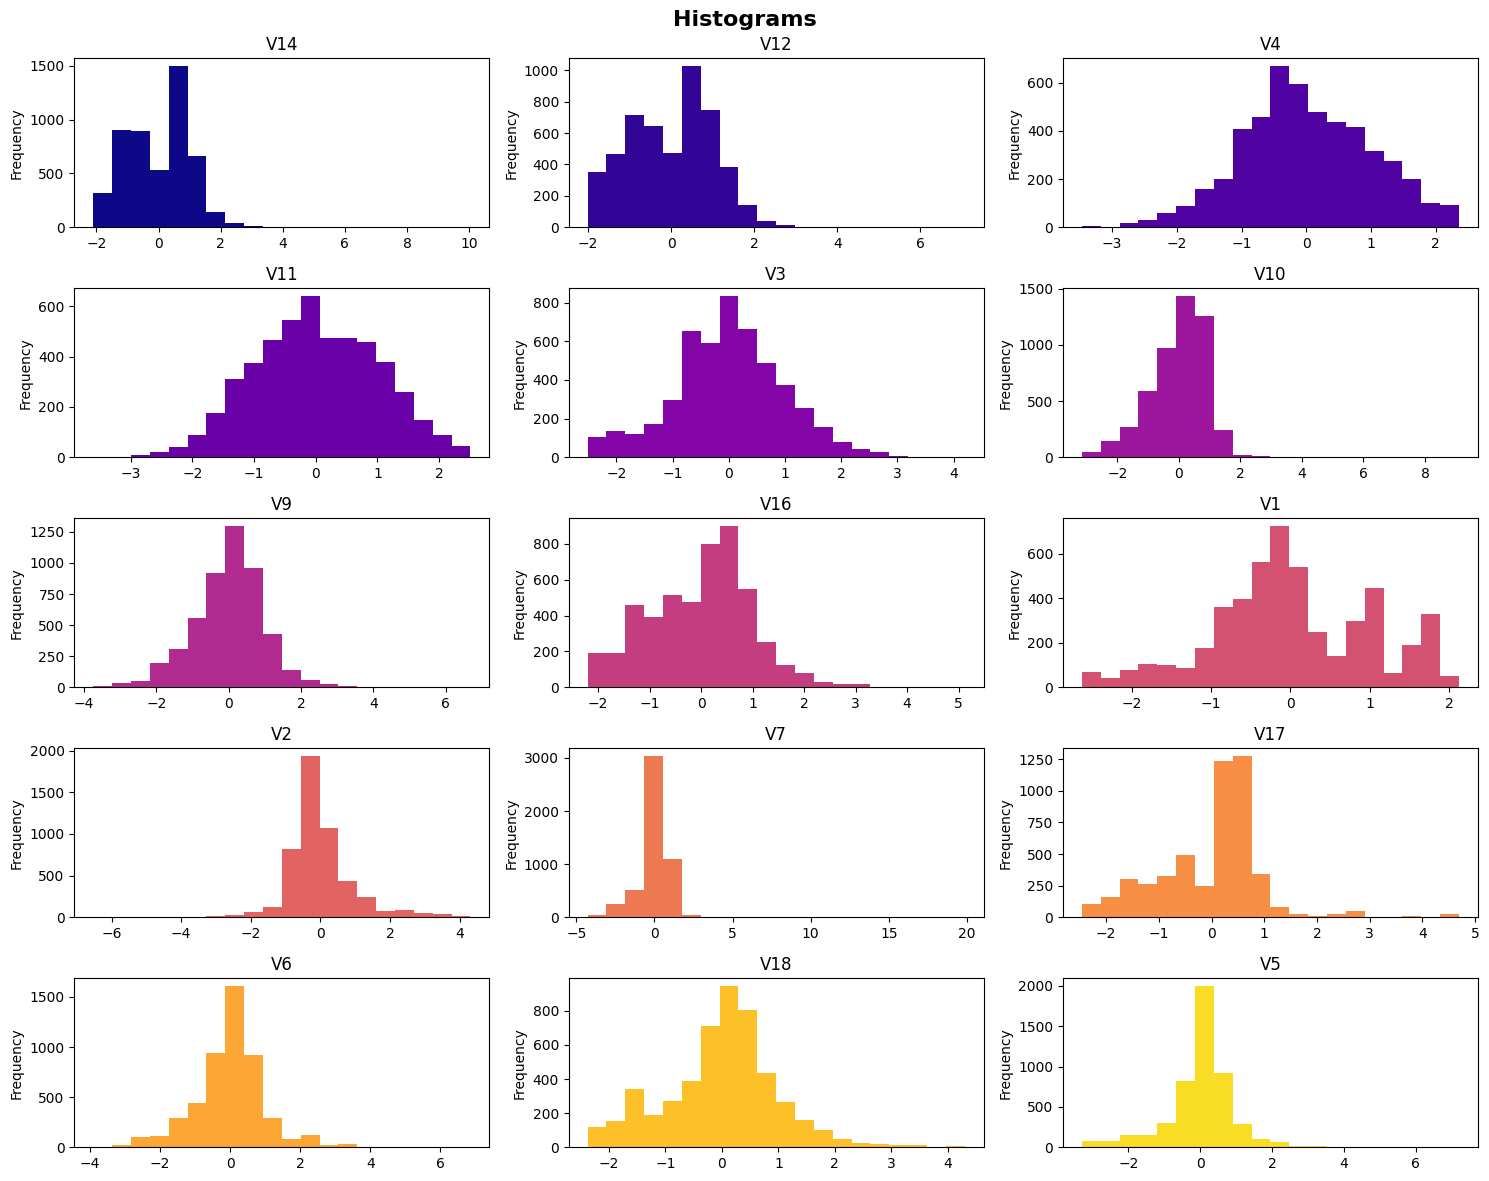

In [453]:


fig, axes = plt.subplots(5, 3, figsize=(15, 12)) 
axes = axes.flatten()

for i, (col, ax) in enumerate(zip(TOP_15_FEATURES, axes)):
    color = COLORMAP(i / len(TOP_15_FEATURES))  
    DATA_DF[col].plot.hist(ax=ax, color=color, bins=20, grid=False)
    ax.set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle('Histograms', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Plotting Box and Whiskers for features 

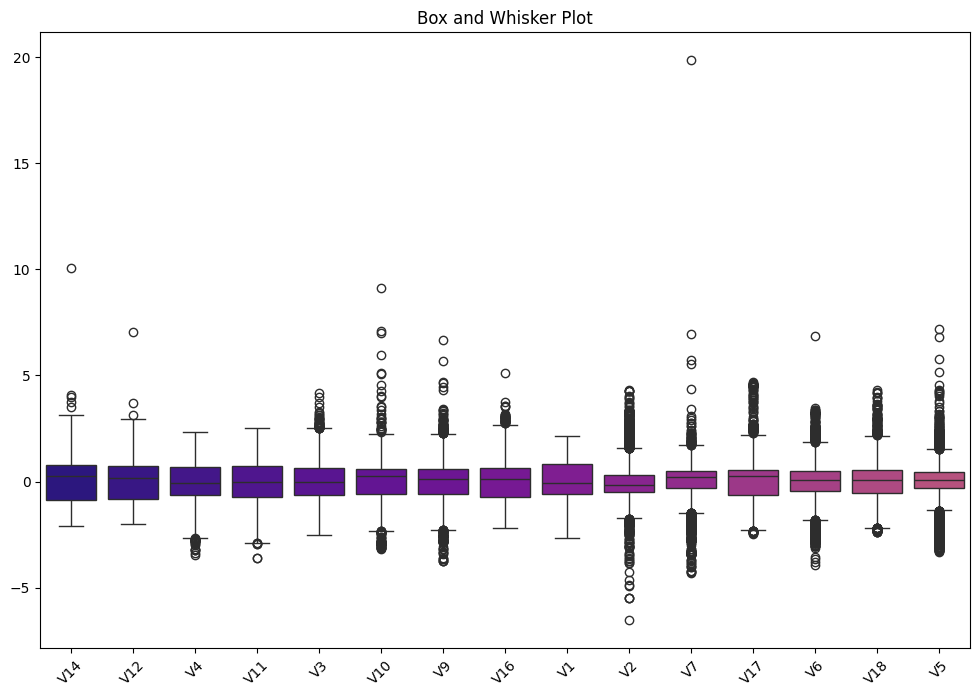

In [454]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=DATA_DF[TOP_15_FEATURES], palette=SNS_COLORMAP)
plt.xticks(rotation=45)  
plt.title("Box and Whisker Plot")
plt.show()

### Answer

1. The stastical values of all the attributes have been studied along with the histogram and boxplots. Observations are:

    a. There are no Null values in the dataset.

    b. Features in data have small variances

    c. There are some outliers in the features.

    d. The target variable Class has equal number of entries for each type.

    f. All the features are continuous and the target is categorical.

2. Treatments required by features:

    a. Standard scaling will be used to standardize the data before fitting a model.

    b. Due to the small amount of outliers and narrow distributions, no outliers will be dropped

# Question 2
Analyze and discuss the relationships between the data attributes and between the data attributes and labels. This involves computing the Pearson Correlation Coefficient (PCC) and generating scatter plots.


In [455]:

TARGET_VARIABLE = 'Class'
FEATURES = DATA_DF.columns.drop([TARGET_VARIABLE])

### Pearson Correlation

Testing the pearson correlation of all feature values compared to the target column, sorting each value by the highest absolute error

In [456]:

results = []
for i in FEATURES:
    stat, p_value = pearsonr(DATA_DF[i], DATA_DF[TARGET_VARIABLE])
    results.append({
        'Target': TARGET_VARIABLE,
        'Compared_Column': i,
        'Statistic': stat,
        'p_value': p_value

    })
            
stat = pd.DataFrame(results).sort_values(by='Statistic', key=abs, ascending=False)
print("Pearson Correlation of all features compared to target value Rock_Type")
print(f"Proportion of statistically significant features: {len(stat[stat['p_value'] < .05]) / len(stat)}")
stat

Pearson Correlation of all features compared to target value Rock_Type
Proportion of statistically significant features: 0.9310344827586207


,Target,Compared_Column,Statistic,p_value
13,Class,V14,-0.805576,0.000000e+00
11,Class,V12,-0.768721,0.000000e+00
3,Class,V4,0.733308,0.000000e+00
10,Class,V11,0.725862,0.000000e+00
9,Class,V10,-0.694657,0.000000e+00
2,Class,V3,-0.674157,0.000000e+00
8,Class,V9,-0.593180,0.000000e+00
15,Class,V16,-0.589014,0.000000e+00
6,Class,V7,-0.520063,0.000000e+00
0,Class,V1,-0.515910,0.000000e+00


### Scatter Plots 

Generating the pair wise scatter plots of the top 10 features with the largest absolute correlation statistic to the target feature. Within each scatter plot we also identify the classes of each point with yellow indicating fradualant activity and blue indicating normal activity

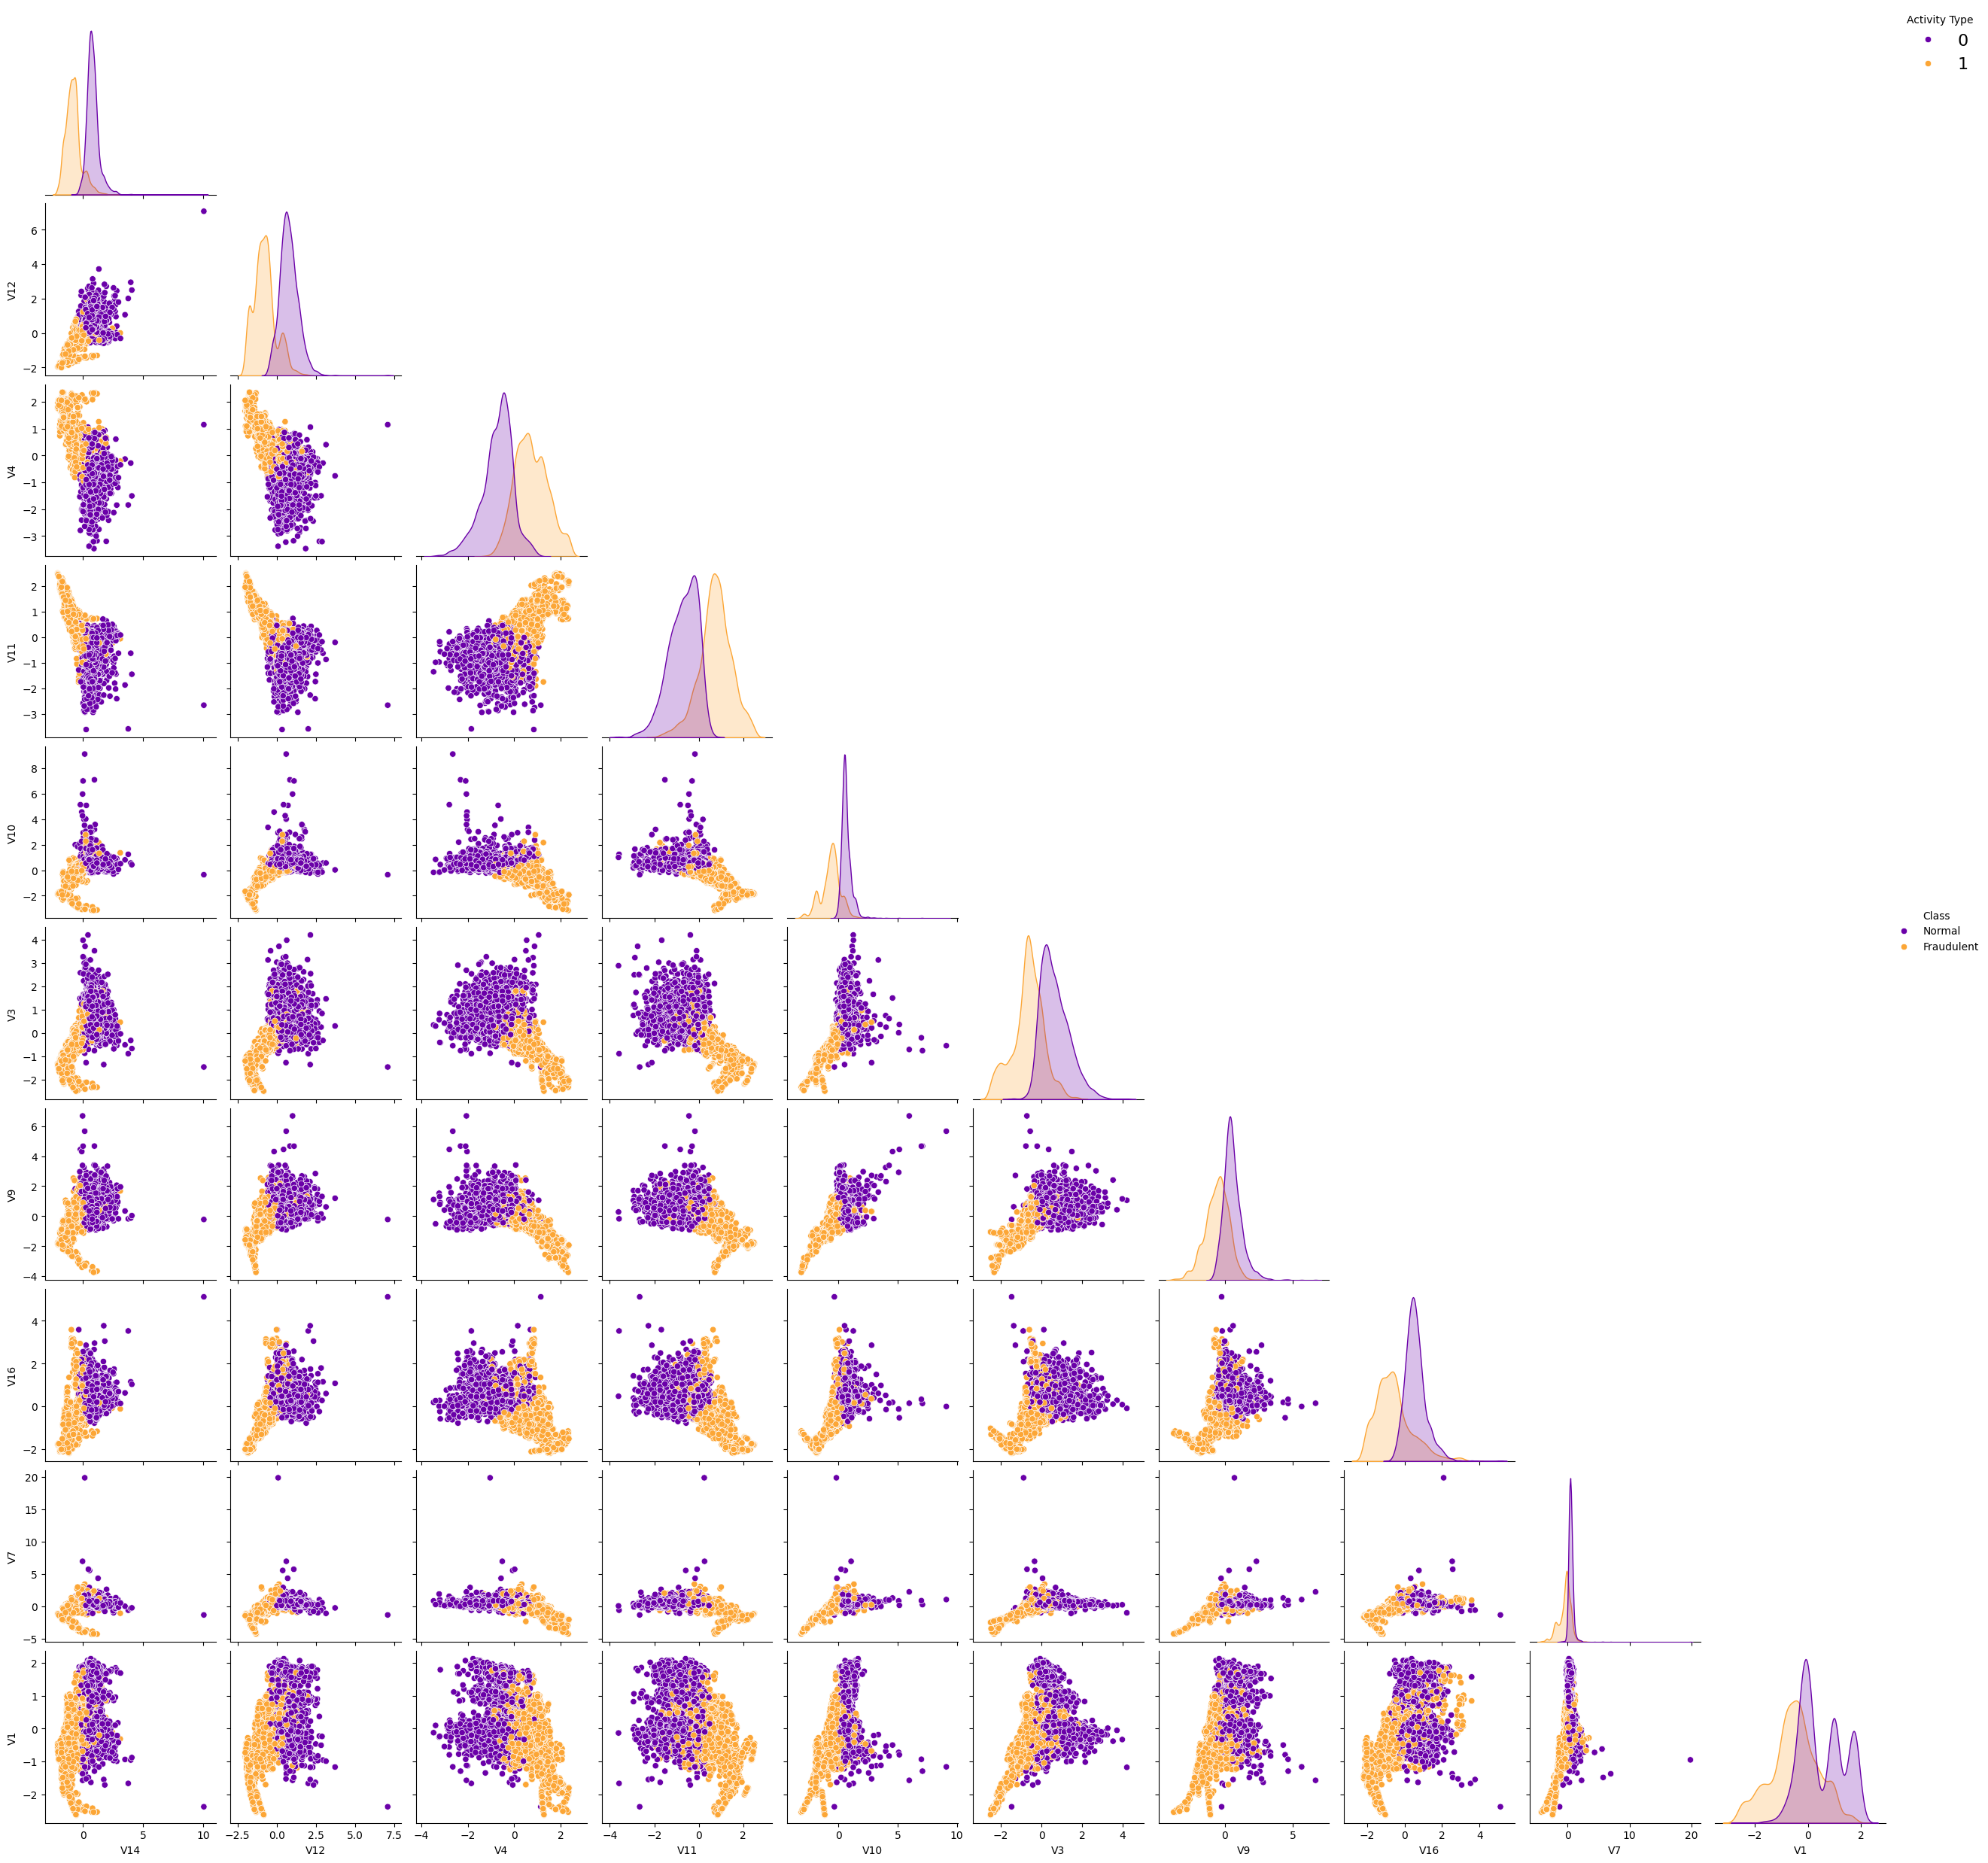

In [457]:

plasma_colors = plt.cm.plasma([0.2, 0.8])
sns_binary = sns.color_palette(plasma_colors)

Top_10_features = stat['Compared_Column'][:10].to_list()
Top_10_features.append('Class')
pairplot = sns.pairplot(DATA_DF[Top_10_features], corner=True, diag_kind='kde', palette=sns_binary, hue='Class')

new_labels = ['Normal', 'Fraudulent']
for t, l in zip(pairplot._legend.texts, new_labels):
    t.set_text(l)

pairplot.add_legend(title='Activity Type', title_fontsize=20, fontsize=16, loc='upper right')
plt.show()

### Correlation Matrix

<Axes: >

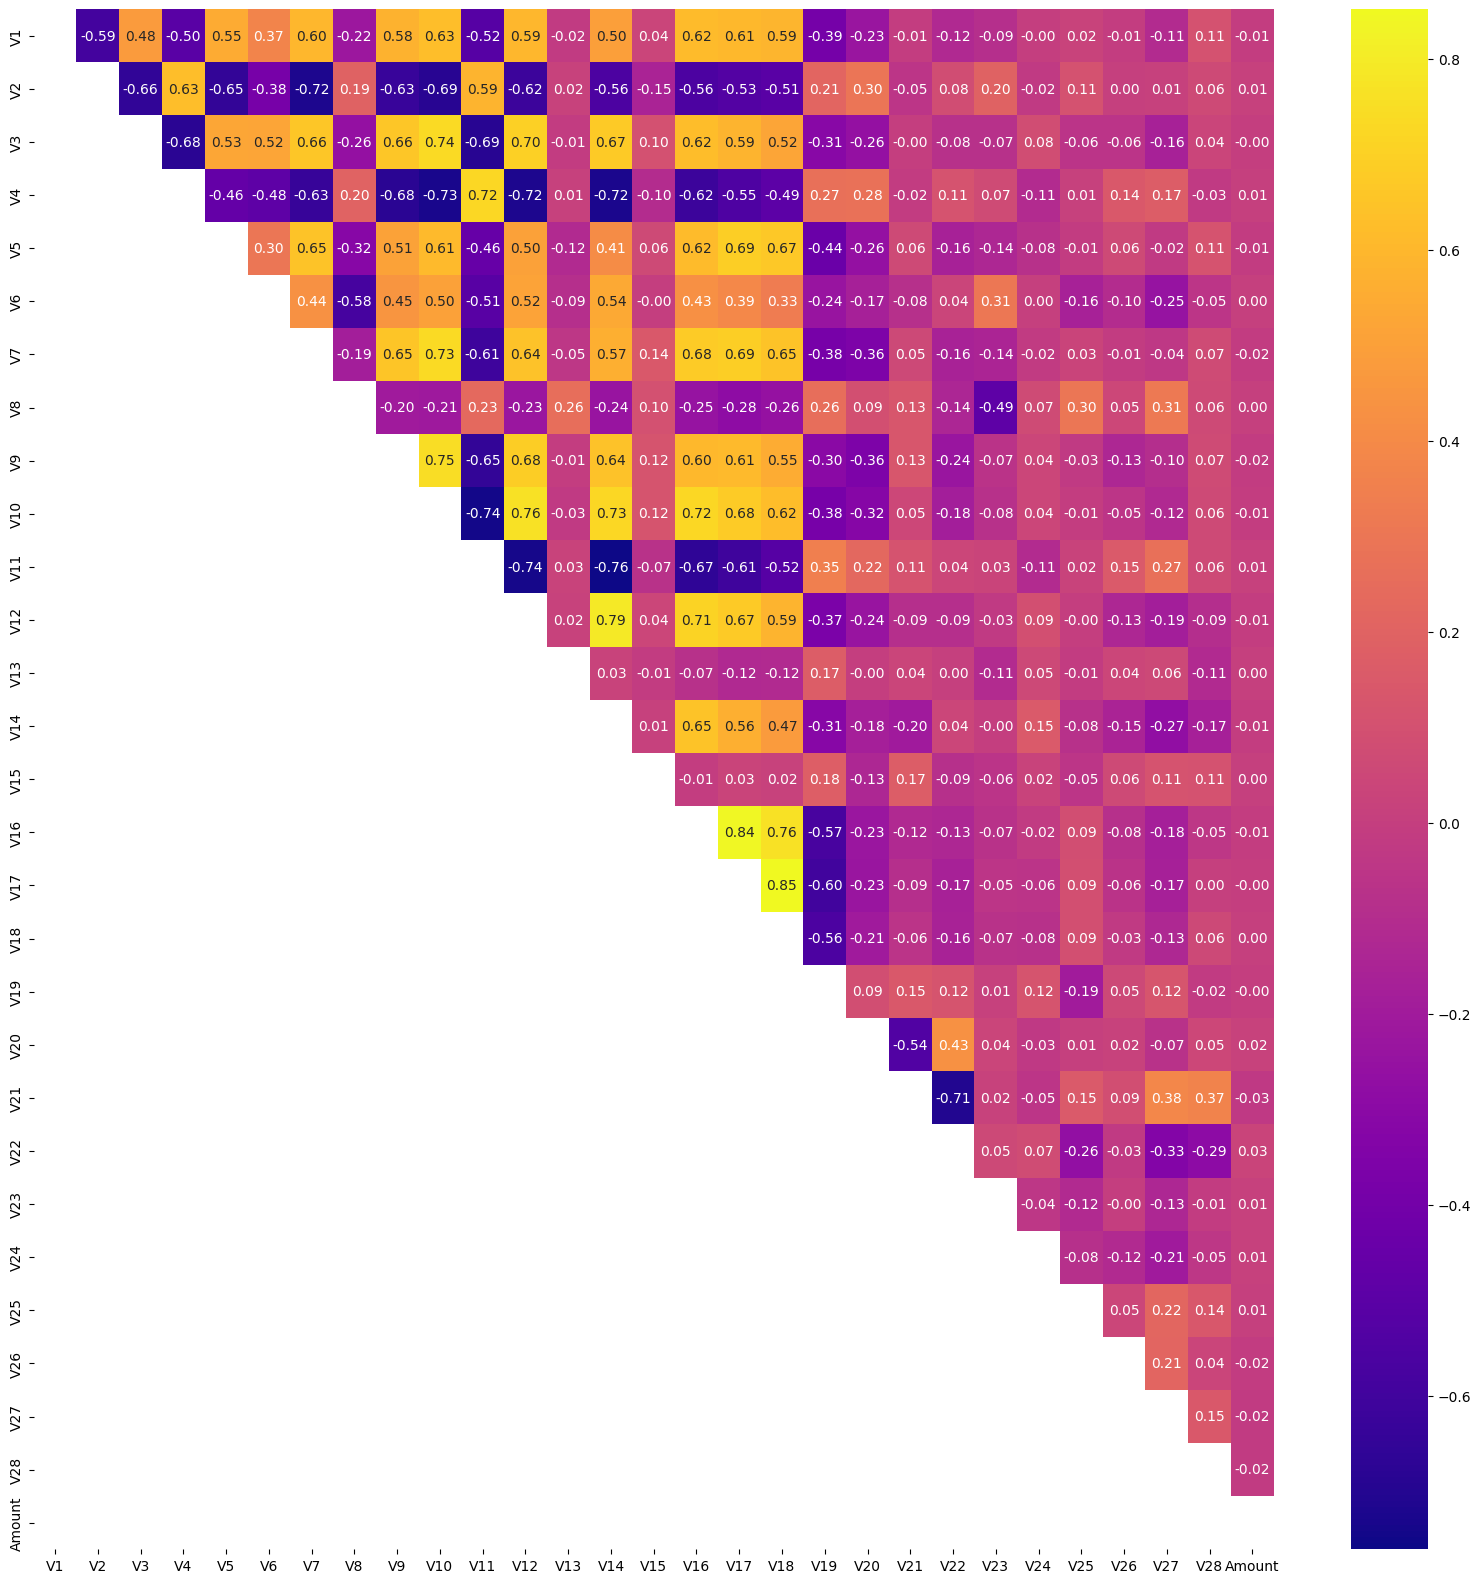

In [458]:
# PCC matrix for attributes and labels
correlation_matrix = DATA_DF[FEATURES].corr()
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap=COLORMAP)

### Observations

1. Relationship between the label and features:

    We notice that when calculating the pearson correlation coefficient 93% of the features provide statistically significant results.  The highest absolute correlation statistic was between the target class and feature v14 with a statistic of -.8. 

2. Relationship between features:

    a. We notice that whitin the top 10 features there is evidence of linear patterns. This is supported by the large coefficient numbers within the correlation matrix. Another important observation is  within the scatter plots there seems to be a clear divide between fradudalnt and normal activities, indicated by the different colors of points. 
    

    

# Question 3
For training data, use token numbers 1-10, for validation 11 to 13, and for testing 14 to 16 (each of the 30 rock subtypes has 16 token numbers).

### Splitting

Scale Data 

In [459]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
DATA_DF[FEATURES] = scaler.fit_transform(DATA_DF[FEATURES])

Split data into Train-Test-Validate sets

In [460]:
# Train Test Validate Split

train_data, test_data = train_test_split(DATA_DF, test_size=0.25, random_state=99)
train_data, validate_data = train_test_split(train_data, test_size=0.25, random_state=99)


Splitting X and Y labels

In [461]:
X_train = train_data.drop(columns=[TARGET_VARIABLE])
y_train = train_data[TARGET_VARIABLE]

X_validate = validate_data.drop(columns=[TARGET_VARIABLE])
y_validate = validate_data[TARGET_VARIABLE]

X_test = test_data.drop(columns=[TARGET_VARIABLE])
y_test = test_data[TARGET_VARIABLE]

Checking the amount of data in each split

In [462]:
print("----------- Shape ------------")
print("training data: ", train_data.shape)
print("validate data: ", validate_data.shape)
print("test data: ", test_data.shape)

print("\n----------- Proportion ------------")
print(f"Training Data: {len(train_data)/ len(DATA_DF):.3f}%")
print(f"Validation Data: {len(validate_data)/ len(DATA_DF):.3f}%")
print(f"Testing Data: {len(test_data)/ len(DATA_DF):.3f}")

----------- Shape ------------
training data:  (2812, 30)
validate data:  (938, 30)
test data:  (1250, 30)

----------- Proportion ------------
Training Data: 0.562%
Validation Data: 0.188%
Testing Data: 0.250


### Check validity of splits

Ensure that each target class is represented in each split

In [463]:

print("Target distribution in training data: ")
print(train_data[TARGET_VARIABLE].value_counts())

print("Target distribution in test data: ")
print(test_data[TARGET_VARIABLE].value_counts())

print("Target validate in training data: ")
print(validate_data[TARGET_VARIABLE].value_counts())

Target distribution in training data: 
Class
0    1420
1    1392
Name: count, dtype: int64
Target distribution in test data: 
Class
1    635
0    615
Name: count, dtype: int64
Target validate in training data: 
Class
0    480
1    458
Name: count, dtype: int64


Checking the box and whisker plots for each column for each split 

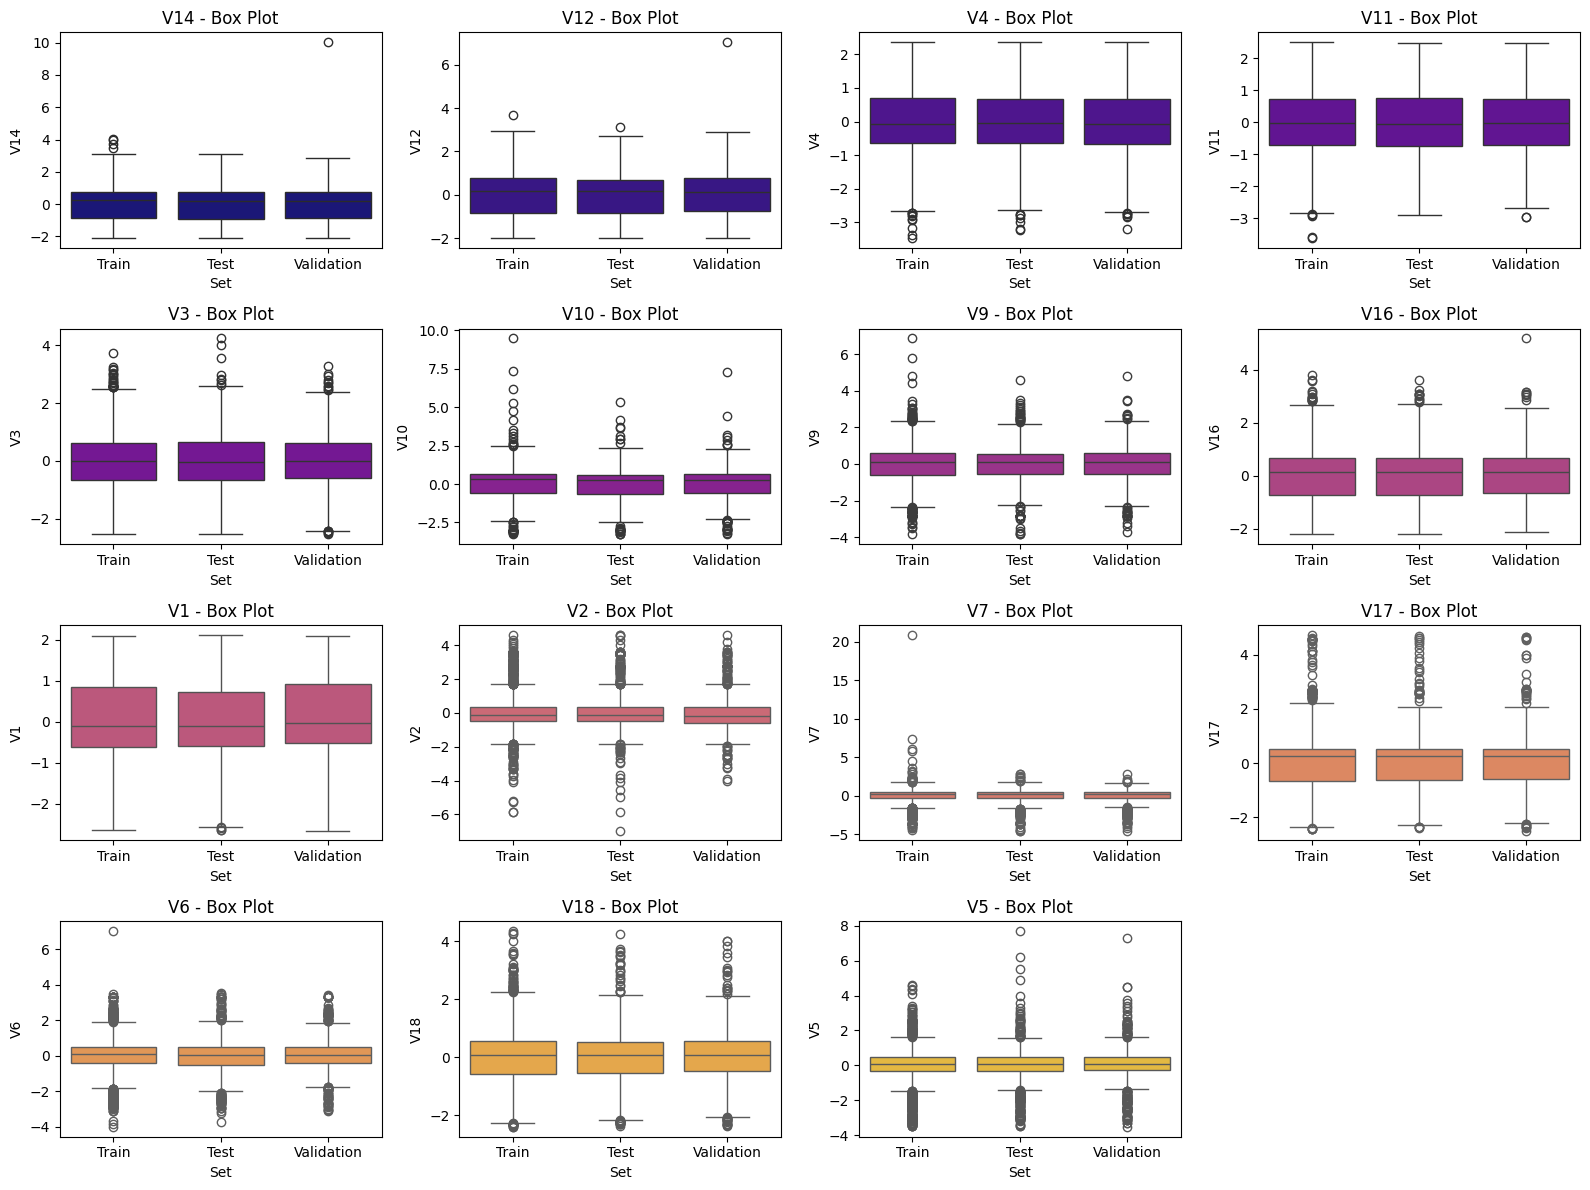

In [464]:
train_data["Set"] = "Train"
test_data["Set"] = "Test"
validate_data["Set"] = "Validation"
combined_data = pd.concat([train_data, test_data, validate_data])

combined_data = combined_data[TOP_15_FEATURES + ['Set']]


plt.figure(figsize=(16, 12))
for i, column in enumerate(combined_data.columns[:-1]):  
    plt.subplot(4, 4, i + 1)
    color = COLORMAP(i / len(combined_data.columns))  
    sns.boxplot(x="Set", y=column, data=combined_data, color=color)
    plt.title(f"{column} - Box Plot")

plt.tight_layout()
plt.show()

Check the mean and std of each column for each split

In [465]:
summary_df = pd.DataFrame()

for column in DATA_DF.columns:
    if column not in ['Class', 'id']:
        stats = {
            f"train_mean": train_data[column].mean(),
            f"train_std": train_data[column].std(),
            f"test_mean": test_data[column].mean(),
            f"test_std": test_data[column].std(),
            f"validate_mean": validate_data[column].mean(),
            f"validate_std": validate_data[column].std()
        }
        summary_df = pd.concat([summary_df, pd.DataFrame(stats, index=[column])])

summary_df.index.name = 'Column'
summary_df.reset_index(inplace=True)

summary_df

,Column,train_mean,train_std,test_mean,test_std,validate_mean,validate_std
0,V1,-0.011498,1.008953,-0.019802,0.976748,0.060858,1.002937
1,V2,0.004954,0.993421,0.008682,1.016866,-0.026422,0.998164
2,V3,-0.004917,1.003394,0.005731,1.011929,0.007103,0.975010
3,V4,0.010168,0.996275,-0.008055,1.000626,-0.019748,1.011460
4,V5,-0.024217,0.983564,0.016556,1.011641,0.050538,1.032041
5,V6,-0.003658,1.003445,-0.008552,1.002960,0.022363,0.986892
6,V7,0.005320,1.046502,-0.009570,0.940513,-0.003195,0.933466
7,V8,0.033181,0.990776,-0.028992,1.030110,-0.060836,0.984217
8,V9,-0.003863,0.999833,0.002939,0.994851,0.007665,1.008850
9,V10,-0.000242,1.003339,-0.015596,0.978017,0.021510,1.019954


### Answer

1. The dataset has been split into Train, Validate and Test components using the train test split, which splits the matrix into a random subset given by the test size. For this model we split the data into ~56% training, ~19% , and 25% testing

2. The split has been verified using mean and standard deviation along with whisker plots to check if it is representative of the original data. The findings state that the split is indeed representative of the data with some minor expected noise.

# Question 4 
Train different classifiers and tweak the hyperparameters to improve performance (you can use the grid search if you want or manually try different values). Report training, validation and testing performance (classification accuracy, precision, recall and F1 score) and discuss the impact of the hyperparameters (use markdown cells in Jupyter Notebook to clearly indicate each solution):


Helpers for grid search

In [466]:
X_pre_defined = np.concatenate((X_train, X_validate), axis=0)
y_pre_defined = np.concatenate((y_train, y_validate), axis=0)

split_index = [-1] * len(X_train) + [0] * len(X_validate)
predefined_split = PredefinedSplit(test_fold = split_index)


def evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, model):
    # Training predictions and metrics
    y_train_pred = model.predict(X_train)
    print("---------------------- Training Metrics ----------------------")
    print("Accuracy: ", round(accuracy_score(y_train, y_train_pred), 3))
    print("Precision: ", precision_score(y_train, y_train_pred, average="macro").round(3))
    print("Recall: ", recall_score(y_train, y_train_pred, average="macro").round(3))
    print("F1 Score: ", f1_score(y_train, y_train_pred, average="macro").round(3))
    
    # Testing predictions and metrics
    y_validate_pred = model.predict(X_validate)
    print("---------------------- Validation Metrics ----------------------")
    print("Accuracy: ", round(accuracy_score(y_validate, y_validate_pred), 3))
    print("Precision: ", precision_score(y_validate, y_validate_pred, average="macro").round(3))
    print("Recall: ", recall_score(y_validate, y_validate_pred, average="macro").round(3))
    print("F1 Score: ", f1_score(y_validate, y_validate_pred, average="macro").round(3))

    # Testing predictions and metrics
    y_test_pred = model.predict(X_test)
    print("---------------------- Testing Metrics ----------------------")
    print("Accuracy: ", round(accuracy_score(y_test, y_test_pred), 3))
    print("Precision: ", precision_score(y_test, y_test_pred, average="macro").round(3))
    print("Recall: ", recall_score(y_test, y_test_pred, average="macro").round(3))
    print("F1 Score: ", f1_score(y_test, y_test_pred, average="macro").round(3))


### Logistic Regression

Use normal logisitic regression instead of the soft max because of binary target class

In [467]:
# Modelling
logreg = LogisticRegression(fit_intercept = True, max_iter = 50)

logreg.fit(X_train, y_train)
# Evaluating on training data
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, logreg)


---------------------- Training Metrics ----------------------
Accuracy:  0.967
Precision:  0.968
Recall:  0.967
F1 Score:  0.967
---------------------- Validation Metrics ----------------------
Accuracy:  0.964
Precision:  0.964
Recall:  0.964
F1 Score:  0.964
---------------------- Testing Metrics ----------------------
Accuracy:  0.95
Precision:  0.951
Recall:  0.951
F1 Score:  0.95


#### Hyper Parameter Tuning using grid search

In [468]:

MODEL = LogisticRegression(fit_intercept=True)

# Define the base parameters and parameter grid
param_grid = {
    'solver': ['lbfgs', 'sag', 'saga', 'newton-cg'],
    'penalty': ['l1', 'l2', 'elsaticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': range(10,220,10)
}


grid_search = RandomizedSearchCV(MODEL, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 1)

grid_search.fit(X_pre_defined, y_pre_defined)

best_logreg = grid_search.best_estimator_

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validated Accuracy:", best_score)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 170, 'C': 10}
Best Cross-Validated Accuracy: 0.9637526652452025


#### Hyperparameters selected for logistic regression:

Solver = lbfgs

penalty = l2

Number of Iterations: 170

C = 10


#### Best Model Performance

In [469]:

evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, best_logreg)



---------------------- Training Metrics ----------------------
Accuracy:  0.969
Precision:  0.97
Recall:  0.969
F1 Score:  0.969
---------------------- Validation Metrics ----------------------
Accuracy:  0.967
Precision:  0.967
Recall:  0.967
F1 Score:  0.967
---------------------- Testing Metrics ----------------------
Accuracy:  0.957
Precision:  0.957
Recall:  0.957
F1 Score:  0.957


#### Observations

Hyper Parameter Tuning did not provide significant increased in performance for any of the metrics 

### Support Vector Machines

In [470]:
svm_model = SVC(probability=True)
# Evaluating on training data
svm_model.fit(X_train, y_train)
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, svm_model)

---------------------- Training Metrics ----------------------
Accuracy:  0.976
Precision:  0.977
Recall:  0.976
F1 Score:  0.976
---------------------- Validation Metrics ----------------------
Accuracy:  0.97
Precision:  0.97
Recall:  0.97
F1 Score:  0.97
---------------------- Testing Metrics ----------------------
Accuracy:  0.958
Precision:  0.959
Recall:  0.958
F1 Score:  0.958


#### Hyper Parameter Tuning using grid search

In [471]:

MODEL = SVC(probability=True)

param_grid = {
    'gamma': [round(x * 0.001, 4) for x in range(0, 201, 10)] + ['scale', 'auto'], 
    'kernel': ["linear", "poly", "rbf", "sigmoid"],                                
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],                             
    'degree': range(1, 6),                                                         
    'coef0': [0.0, 0.1, 0.5, 1.0, 2.0, 5.0],                                                                                       
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],                                                
    'class_weight': [None, 'balanced']                                              
}

grid_search = RandomizedSearchCV(MODEL, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 0)
grid_search.fit(X_pre_defined, y_pre_defined)

best_svm_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Best Parameters: {'tol': 0.1, 'kernel': 'rbf', 'gamma': 0.09, 'degree': 1, 'coef0': 5.0, 'class_weight': None, 'C': 1000}
Best Cross-Validated Accuracy: 0.9776119402985075


#### Selected Hyper Parameters for SVM:

tol: .01

Kernel: rbf

Gamma: 0.09

Degree: 1

coef0: 5.0 

class_weight: None

C: 1000



#### Best Model Performance

In [472]:

evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, best_svm_model)

---------------------- Training Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Validation Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Testing Metrics ----------------------
Accuracy:  0.982
Precision:  0.982
Recall:  0.982
F1 Score:  0.982


### Observations

Hyper Paramater Tuning for SVM led to much more significant increases in performance than hyper parameter tuning on Logistic Regression. This led to perfect classification on training and validation and improved scoring on Testing sets  

### Random Forest classifier

In [473]:
random_forest = RandomForestClassifier(random_state=9)
random_forest.fit(X_train, y_train)
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, random_forest)


---------------------- Training Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Validation Metrics ----------------------
Accuracy:  0.974
Precision:  0.975
Recall:  0.974
F1 Score:  0.974
---------------------- Testing Metrics ----------------------
Accuracy:  0.963
Precision:  0.964
Recall:  0.964
F1 Score:  0.963


#### Hyper Parameter Tuning using grid search

In [474]:

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 500],                   
    'max_depth': [None, 5, 10, 20, 30, 40, 50],                      
    'min_samples_split': [2, 5, 10, 20, 50],                       
    'min_samples_leaf': [1, 2, 4, 10, 20, 50],                     
    'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.5, 0.8],        
    'bootstrap': [True, False],                                    
    'criterion': ['gini', 'entropy', 'log_loss']                    
}

rf = RandomForestClassifier(random_state = 9)

grid_search = RandomizedSearchCV(rf, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 0)

grid_search.fit(X_pre_defined, y_pre_defined)

best_random_forest = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Best Cross-Validated Accuracy: 0.9754797441364605


#### Best Parameters for Random Forest:

Number of Estimators: 500

Min Samples Split: 10

Min Samples Leaf: 2

Max Features: log2

Max Depth: 20

Criterion: Log Loss

Bootstap: False


#### Best Model Parameter

In [475]:

evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, best_random_forest)

---------------------- Training Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Validation Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Testing Metrics ----------------------
Accuracy:  0.976
Precision:  0.976
Recall:  0.976
F1 Score:  0.976


#### Feature Importance 

In [476]:
feature_imps = list(best_random_forest.feature_importances_)
fi_df = pd.DataFrame(columns = ["Feature", "Importance"])

for itr in range(len(X_train.columns)):
    curr_row = [X_train.columns[itr], feature_imps[itr]]
    fi_df.loc[len(fi_df)] = curr_row

In [477]:
fi_df.sort_values(by = ["Importance"], ascending = False)

,Feature,Importance
13,V14,0.401990
9,V10,0.196570
11,V12,0.095924
3,V4,0.077523
16,V17,0.059169
10,V11,0.026633
2,V3,0.019902
7,V8,0.009249
15,V16,0.008166
0,V1,0.007767



Hyper Paramater Tuning for Random Forest led to a slight increase in performance on all metrics. Random Forest Model also scores at 100% on both the training and testing sets and at ~97.6% on the testing set. Although both Random Forest and SVM have identical training and validation scores, they slightly differ in testing scores. I believe this is the result of overfitting of the Random Forest model 

### Answer

1. 3 classifiers have been tried for the given dataset along with hyperparameter tuning for all of them. The best hyperparameters have been noted in the above markdown cells along with the train, test and validation metrics for each model.

2. Impact of hyperparameters:

    a. Logitic regression:

        solver: Set to lbfgs. Efficient for large datasets and supports regularization.

        penalty: Using l2. Adds regularization to prevent overfitting, improving generalization.

        max_iter: Set to 170. Sufficient iterations to ensure model convergence.

        C: The best value is 10. Controls regularization strength; lower values increase regularization, while higher values reduce it, allowing the model to fit more complex patterns.
    
    b. SVM:

        tol: The best value is 0.01. A lower tolerance increases precision but may slow convergence.

        kernel: Set to rbf. The RBF kernel captures non-linear relationships effectively.

        gamma: The optimal value is 0.09. Controls the influence of each data point; lower values create a smoother decision boundary.

        degree: Set to 1. Only applies to polynomial kernels but included to avoid overfitting.

        coef0: Set to 5.0. Impacts the decision boundary in polynomial and sigmoid kernels, though minimal effect with RBF.

        class_weight: Set to None. Classes are weighted equally, effective when data is balanced.

        C: The best value is 1000. A high C reduces margin error, allowing the model to fit harder-to-separate data points.

    c. Random Forest:

        n_estimators: The best value is 500. More estimators reduce variance, leading to better generalization.

        max_depth: The optimal depth is 20. Greater depth can lead to overfitting, while a shallow tree risks underfitting.

        min_samples_split: The best value is 10. Higher values prevent splits on small samples, creating simpler trees and reducing overfitting.

        min_samples_leaf: The best value is 2. Ensures each leaf has at least two samples, which smooths predictions and avoids overfitting.

        max_features: Set to log2. Limits features at each split, adding diversity and reducing overfitting.

        criterion: Log Loss. Prioritizes probability accuracy, useful for probabilistic predictions.

        bootstrap: Set to False. Without bootstrapping, each tree uses the entire dataset, stabilizing predictions.

# Question 5
Combine your classifiers into an ensemble and try to outperform each individual classifier on the validation set. Once you have found a good one, try it on the test set. Describe and discuss your findings.

### Best Models

recall our models with best hyperparameters

In [478]:

print("---------------------- Best Logistic Regression Model ----------------------")
print(best_logreg)

print("---------------------- Best Support Vector Model ----------------------")
print(best_svm_model)

print("---------------------- Best Random Forest Model ----------------------")
print(best_random_forest)


---------------------- Best Logistic Regression Model ----------------------
LogisticRegression(C=10, max_iter=170)
---------------------- Best Support Vector Model ----------------------
SVC(C=1000, coef0=5.0, degree=1, gamma=0.09, probability=True, tol=0.1)
---------------------- Best Random Forest Model ----------------------
RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=0.5,
                       min_samples_leaf=4, n_estimators=500, random_state=9)


### Hard Voting Ensemble

In [479]:
models = [("lr", best_logreg), ("svm", best_svm_model), ("rf", best_random_forest)]

In [480]:
vc_hard = VotingClassifier(estimators = models, voting = 'hard')
vc_hard.fit(X_train, y_train)
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, vc_hard)

---------------------- Training Metrics ----------------------
Accuracy:  0.999
Precision:  0.999
Recall:  0.999
F1 Score:  0.999
---------------------- Validation Metrics ----------------------
Accuracy:  0.977
Precision:  0.977
Recall:  0.977
F1 Score:  0.977
---------------------- Testing Metrics ----------------------
Accuracy:  0.975
Precision:  0.975
Recall:  0.975
F1 Score:  0.975


### Soft Voting Ensemble

In [481]:
vc_soft = VotingClassifier(estimators = models, voting = 'soft')
vc_soft.fit(X_train, y_train)
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, vc_soft)

---------------------- Training Metrics ----------------------
Accuracy:  0.999
Precision:  0.999
Recall:  0.999
F1 Score:  0.999
---------------------- Validation Metrics ----------------------
Accuracy:  0.977
Precision:  0.977
Recall:  0.977
F1 Score:  0.977
---------------------- Testing Metrics ----------------------
Accuracy:  0.978
Precision:  0.978
Recall:  0.978
F1 Score:  0.978


### Comparisons of all models on the Test Set

In [482]:
model_eval = [("logistic_regression", best_logreg), ("Support_vector_Machine", best_svm_model), ("random_forest", best_random_forest), ('Ensemble_soft_voting', vc_soft), ('Ensemble_hard_voting', vc_hard) ]
cumulative_results = {name: {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1 Score': 0} for name, _ in model_eval}


n_runs = 10

for _ in range(n_runs):
    for name, model in model_eval:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        cumulative_results[name]['Accuracy'] += accuracy_score(y_test, y_pred)
        cumulative_results[name]['Precision'] += precision_score(y_test, y_pred, average="macro")
        cumulative_results[name]['Recall'] += recall_score(y_test, y_pred, average="macro")
        cumulative_results[name]['F1 Score'] += f1_score(y_test, y_pred, average="macro")

# Calculate averages
average_results = []
for name, metrics in cumulative_results.items():
    average_results.append({
        'model': name,
        'Accuracy': metrics['Accuracy'] / n_runs,
        'Precision': metrics['Precision'] / n_runs,
        'Recall': metrics['Recall'] / n_runs,
        'F1 Score': metrics['F1 Score'] / n_runs
    })

# Convert to DataFrame and display
result = pd.DataFrame(average_results).sort_values(by=['Accuracy'], ascending=False)
result

,model,Accuracy,Precision,Recall,F1 Score
3,Ensemble_soft_voting,0.9776,0.977600,0.977722,0.977599
1,Support_vector_Machine,0.9768,0.976767,0.976858,0.976797
4,Ensemble_hard_voting,0.9752,0.975249,0.975360,0.975199
2,random_forest,0.9744,0.974521,0.974598,0.974400
0,logistic_regression,0.9504,0.950518,0.950592,0.950399


#### Observations

The soft voting ensemble method has the highest accuracy (97.76%) and F1 Score (0.9776), making it the best-performing model overall.
Soft voting, which averages the probability estimates across models, likely benefits from combining strengths of multiple classifiers, resulting in higher performance.

SVM achieved an accuracy of 97.68% and an F1 Score of 0.9768, placing it very close to the soft voting ensemble in performance.
This shows that SVM is particularly effective on this dataset, potentially due to its ability to maximize the margin between classes.
Hard Voting Ensemble:

Hard voting, where each model casts a vote, achieved an accuracy of 97.52% and F1 Score of 0.9752, slightly lower than soft voting.
While still effective, hard voting may be slightly less consistent compared to soft voting due to the strict majority rule. This model probably performs worse than SVM because only SVM and not the other models are able to correcly identify difficult points. 

The random forest model performed well, with an accuracy of 97.44% and an F1 Score of 0.9744.
This result shows that random forest is competitive but may not be as optimal as the voting ensembles or SVM for this specific dataset.

Logistic regression has the lowest performance among the models, with an accuracy of 95.04% and an F1 Score of 0.9504.
This indicates that logistic regression may be too simple when compared to the performance of more complex models